In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.std((Image_RGB))

815


In [4]:
#for i in range(5):
#    Image_RGB[:,:,:,i] -= np.mean(Image_RGB[:,:,:,i])
#    Image_RGB[:,:,:,i] /= np.std((Image_RGB[:,:,:,i]))
#    Image_RGB[:,:,:,i] /= 2

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   8.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          9.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   1.00000000e+01,   8.00000000e+00,
          1.10000000e+01,   1.50000000e+01,   1.70000000e+01,
          2.00000000e+01,   1.80000000e+01,   2.60000000e+01,
          2.80000000e+01,   2.70000000e+01,   2.40000000e+01,
          3.10000000e+01,   2.70000000e+01,   4.20000000e+01,
          3.90000000e+01,   4.00000000e+01,   4.90000000e+01,
          5.10000000e+01,   6.10000000e+01,   6.60000000e+01,
          7.70000000e+01,   8.50000000e+01,   1.11000000e+02,
          1.12000000e+02,   1.40000000e+02,   1.23000000e+02,
          1.58000000e+02,   2.01000000e+02,   1.73000000e+02,
        

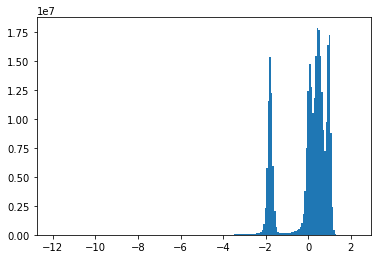

In [6]:
plt.hist(Image_RGB.reshape(-1,),200)

In [7]:
np.std(Image_RGB)

1.0000000000000051

In [8]:
np.min(Image_RGB)

-12.046517871261704

In [32]:
batch_size =100
latent_dim = 2
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='relu')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)


In [33]:
autoencoder.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(train_data[12000:14000],train_data[12000:14000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2000 samples
Epoch 1/100
12000/12000 [==============================] - 26s - loss: 938.9611 - val_loss: 872.3479
Epoch 2/100
12000/12000 [==============================] - 23s - loss: 790.6534 - val_loss: 834.9914
Epoch 3/100
12000/12000 [==============================] - 23s - loss: 776.9250 - val_loss: 787.1449
Epoch 4/100
12000/12000 [==============================] - 23s - loss: 771.1827 - val_loss: 784.0327
Epoch 5/100
12000/12000 [==============================] - 23s - loss: 767.7904 - val_loss: 778.2806
Epoch 6/100
12000/12000 [==============================] - 24s - loss: 765.4893 - val_loss: 777.9772
Epoch 7/100
12000/12000 [==============================] - 24s - loss: 763.7435 - val_loss: 778.0054
Epoch 8/100
12000/12000 [==============================] - 24s - loss: 763.1459 - val_loss: 783.7564
Epoch 9/100
 6800/12000 [================>.............] - ETA: 9s - loss: 766.9105

KeyboardInterrupt: 

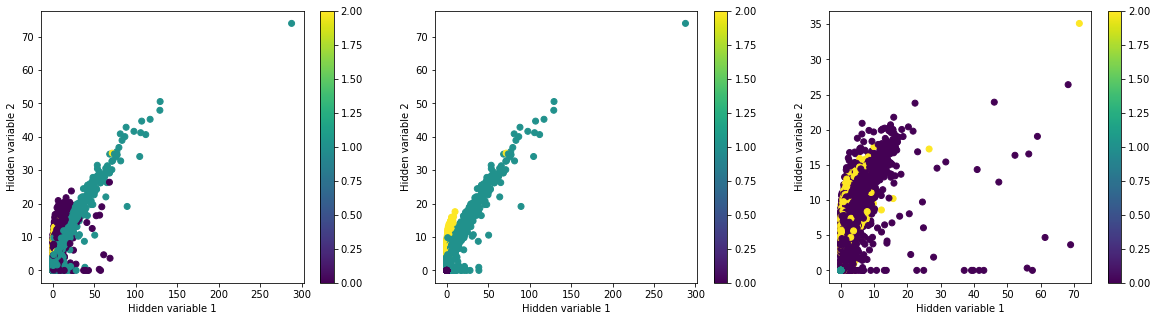

In [34]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img,encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

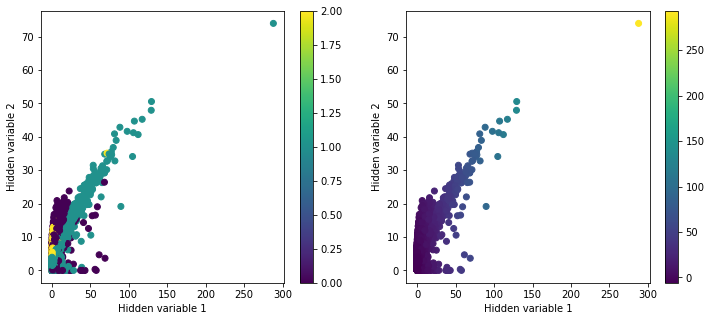

In [45]:
lower_lim = 0
upper_lim = 14000


vis = Model(input_img, encoded)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

4000


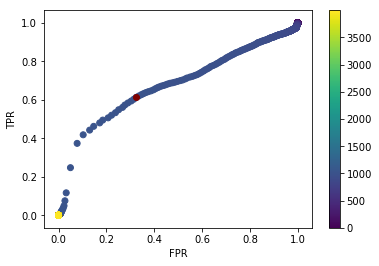

In [51]:
Y_pred = -Y_pred
thr_min = -100
thr_max = 300
test_accuracy = 0.1
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

In [52]:
from sklearn import metrics
print("AUC:",metrics.auc(FPR, TPR))

AUC: 0.6725351554


In [35]:
size = np.zeros((upper_lim-lower_lim,))
threshold = np.zeros_like(train_data[lower_lim:upper_lim])
pixel_sum = np.zeros((upper_lim-lower_lim,))
threshold[np.exp(train_data[lower_lim:upper_lim])>np.mean(np.exp(train_data[lower_lim:upper_lim]))]=1

for i in range(len(x_vis)):
    pixel_sum[i] = np.mean(np.exp(train_data[lower_lim:upper_lim][i]))
    size[i] = np.sum(threshold[i])/64/64/5

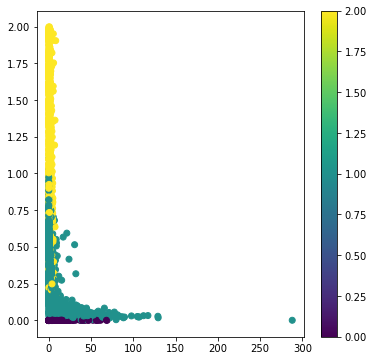

In [43]:
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,Redshift[lower_lim:upper_lim],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.show()

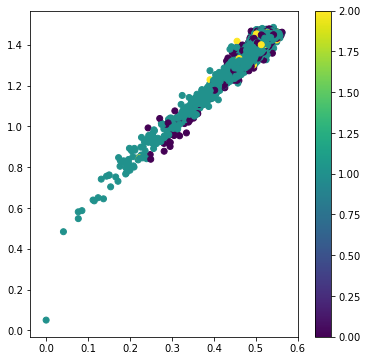

In [39]:
plt.figure(figsize=(6, 6))
plt.scatter(size ,pixel_sum,c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.show()